In [13]:
#import stuff
import os
import glob
import h5py
import shutil
import imgaug as aug  augment data
import numpy as np   linear algebra
import pandas as pd   data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt  plot stuff/show images
import matplotlib.image as mimg
import imgaug.augmenters as iaa  augment data(data is imbalanced)
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path #get data
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input #transfer learning
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
#convolutional nueral networks
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline
print(os.listdir("Data/"))

['augmented data', 'chest_xray', 'COVID-19_Radiography_Dataset', 'NonAugmentedTrain', 'Pneumonia_and_COVID19']


In [41]:
#get data
data_dir1 = Path('Data/chest_xray')
data_dir2 = Path('Data/Covid19-detection-xray-dataset')
data_dir3 = Path('Data/COVID-19_Radiography_Dataset')
data_dir4 = Path('Data/Pneumonia_and_COVID19')


In [42]:
data = []
normal_data = []
bacterial_data = []
viral_data = []

In [43]:
loop_dir1 = ['test', 'train', 'val']
for i in loop_dir1:
    normal_dir1 = data_dir1 / i / 'NORMAL'
    pneumonia_dir1 = data_dir1 / i / 'PNEUMONIA'
    normal_cases1 = normal_dir1.glob('*.jpeg')
    pneumonia_cases1 = pneumonia_dir1.glob('*.jpeg')
    for img in normal_cases1:
        normal_data.append((img,0))
    for img in pneumonia_cases1:
        if "bacteria" in str(img):
            bacterial_data.append((img,1))
        elif "virus" in str(img):
            viral_data.append((img,2))

In [44]:
loop_dir2 = ['NonAugmentedTrain', 'ValData', 'TrainData']
for i in loop_dir2:
    normal_dir2 = data_dir2 / i / 'Normal'
    bacterial_dir2 = data_dir2 / i / 'BacterialPneumonia'
    viral_dir2 = data_dir2 / i / 'ViralPneumonia'
    normal_cases2 = normal_dir2.glob('*.jpeg')
    bacterial_cases2 = bacterial_dir2.glob('*.jpeg')
    viral_cases2 = viral_dir2.glob('*.jpeg')
    for img in normal_cases2:
        normal_data.append((img,0))
    for img in bacterial_cases2:
        bacterial_data.append((img,1))
    for img in viral_cases2:
        viral_data.append((img,2))

In [45]:
normal_dir3 = data_dir3 / 'NORMAL'
viral_dir3 = data_dir3 / 'Viral Pneumonia'
normal_cases3 = normal_dir3.glob('*.png')
viral_cases3 = viral_dir3.glob('*.png')
for i, img in enumerate(normal_cases3):
    im = Image.open(img)
    rgb_img = im.convert('RGB')
    rgb_img.save('normal('+str(i)+').jpeg', quality=100, subsampling = 0)
    data.append((rgb_img,0))
for i, img in enumerate(viral_cases3):
    im = Image.open(img)
    rgb_img = im.convert('RGB')
    rgb_img.save('viral('+str(i)+').jpeg', quality=100, subsampling = 0)
    data.append((rgb_img,2))
    
    
for img in normal_cases2:
    rgb_img = cv2.imread(img)
    cv2.imwrite(img[:-3] + 'jpeg', rgb_img)
    data.append((img,0))
for img in viral_cases2:
    rgb_img = cv2.imread(img)
    cv2.imwrite(img[:-3] + 'jpeg', rgb_img)
    data.append((img,2))


In [46]:
loop_dir4 = ['TEST', 'TRAIN']
for i in loop_dir4:
    viral_dir4 = data_dir4 / i / 'PNEUMONIA (VIRUS)'
    viral_cases4 = viral_dir4.glob('*.jpeg')
    for img in viral_cases4:
        viral_data.append((img,2))

In [47]:
print('number of normal cases: ' + str(len(normal_data)))
print('number of bacterial cases: ' + str(len(bacterial_data)))
print('number of viral cases: ' + str(len(viral_data)))

number of normal cases: 3814
number of bacterial cases: 4404
number of viral cases: 4015


In [48]:
data = normal_data + bacterial_data + viral_data
del normal_data, bacterial_data, viral_data, data_dir1, data_dir2, data_dir3, data_dir4

In [49]:
data = pd.DataFrame(data, columns=['image', 'label'],index=None)
#shuffle
data = data.sample(frac=1.).reset_index(drop=True)
#print
data.head()    

,image,label
0,Data\chest_xray\train\NORMAL\IM-0453-0001-0002...,0
1,Data\Pneumonia_and_COVID19\TRAIN\PNEUMONIA (VI...,2
2,Data\Covid19-detection-xray-dataset\TrainData\...,0
3,Data\Pneumonia_and_COVID19\TRAIN\PNEUMONIA (VI...,2
4,Data\Pneumonia_and_COVID19\TRAIN\PNEUMONIA (VI...,2


C:\Users\AJEM\AppData\Local\Temp\ipykernel_8572\2610879118.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cases_count.index, y= cases_count.values, palette=colors)


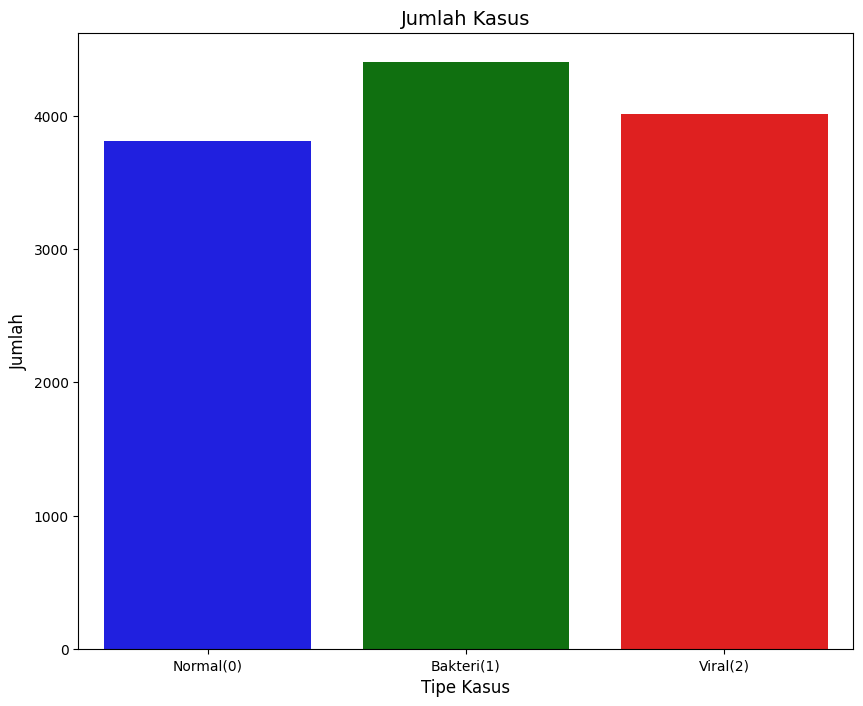

In [51]:
# Mendefinisikan warna untuk setiap kelas
colors = ['blue', 'green', 'red']

# Menghitung jumlah kasus untuk setiap kelas
cases_count = data['label'].value_counts()

# Membuat plot
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values, palette=colors)
plt.title('Jumlah Kasus', fontsize=14)
plt.xlabel('Tipe Kasus', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Bakteri(1)', 'Viral(2)'])
plt.show()

# Menghapus variabel cases_count dari memori
del cases_count

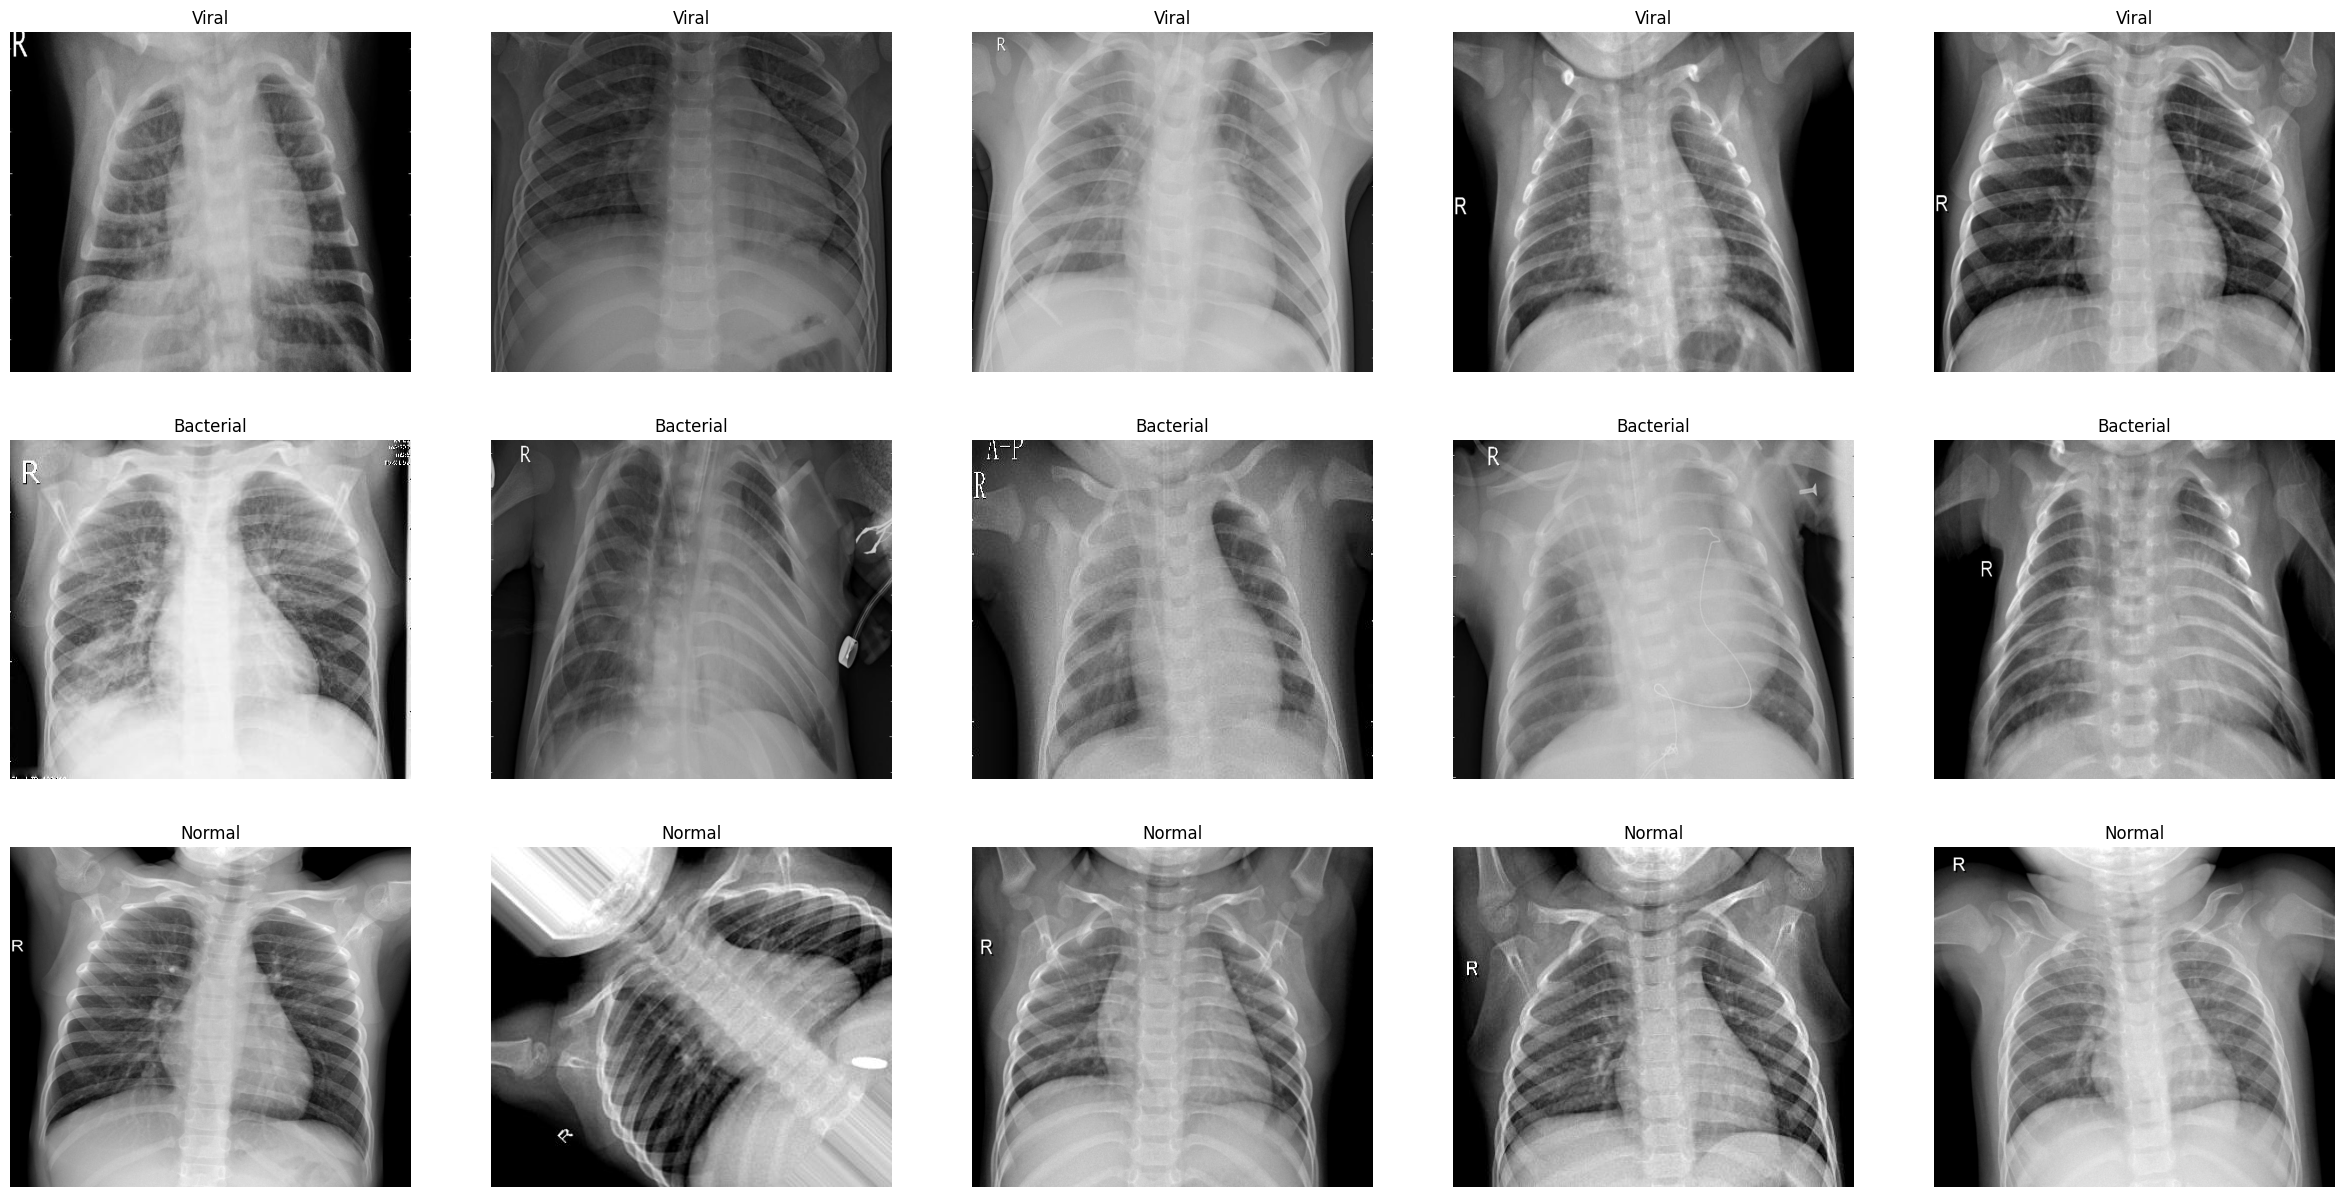

In [52]:
#show sample
viral_samples = (data[data['label']==2]['image'].iloc[:5]).tolist()
bacterial_samples = (data[data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (data[data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above 3 lists
samples = viral_samples + bacterial_samples + normal_samples
del viral_samples, normal_samples, bacterial_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,15))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Viral")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Bacterial")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [53]:
data = data.iloc[: int(data.shape[0]/2)]
print(data.shape)

(6116, 2)


In [54]:
image_data = []
label_data = []
for index, d in data.iterrows():
    img = d['image']
    l = d['label']
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(l, num_classes=3)
    image_data.append(img)
    label_data.append(label)
image_data = np.array(image_data)
label_data = np.array(label_data)
del data

In [55]:
image_train, image_validate, image_test = np.split(image_data, [int(.7*len(image_data)), int(.85*len(image_data))])
label_train, label_validate, label_test = np.split(label_data, [int(.7*len(label_data)), int(.85*len(label_data))])
print('number of training images and labels: ' + str(len(image_train)) + ' and ' + str(len(label_train)))
print('number of validation images and labels: ' + str(len(image_validate)) + ' and ' + str(len(label_validate)))
print('number of test images and labels: ' + str(len(image_test)) + ' and ' + str(len(label_test)))
del image_data, label_data

number of training images and labels: 4281 and 4281
number of validation images and labels: 917 and 917
number of test images and labels: 918 and 918


In [56]:
from keras.applications.vgg16 import VGG16
vgg16_weights = 'Model/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
vgg16_model = VGG16(weights=vgg16_weights)
new_vgg16 = Sequential()
for layer in vgg16_model.layers[:-1]:
    new_vgg16.add(layer)
new_vgg16.add(Dense(3, activation='softmax'))
del vgg16_model, vgg16_weights
#new_vgg16.summary()

In [58]:
new_vgg16.compile(loss='categorical_crossentropy',
              optimizer= Adam(lr=0.0001),
              metrics=['accuracy'])

In [59]:
early_stopping_monitor = EarlyStopping(
    monitor='val_acc',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

In [62]:
batch_size = 16

histo = new_vgg16.fit(image_train, label_train, \
                    validation_data=(image_validate, label_validate), \
                    epochs=20, callbacks=[early_stopping_monitor], batch_size=batch_size)

Epoch 1/20
268/268 [==============================] - ETA: 0s - loss: 1.4216 - accuracy: 0.3558WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1836s 7s/step - loss: 1.4216 - accuracy: 0.3558 - val_loss: 1.0714 - val_accuracy: 0.3839
Epoch 2/20
268/268 [==============================] - ETA: 0s - loss: 1.0728 - accuracy: 0.4618WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1779s 7s/step - loss: 1.0728 - accuracy: 0.4618 - val_loss: 0.7470 - val_accuracy: 0.5889
Epoch 3/20
268/268 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.6192WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1567s 6s/step - loss: 0.8181 - accuracy: 0.6192 - val_loss: 0.7610 - val_accuracy: 0.6576
Epoch 4/20
268/268 [==============================] - ETA: 0s - loss: 0.7604 - accuracy: 0.6480WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1562s 6s/step - loss: 0.7604 - accuracy: 0.6480 - val_loss: 0.6753 - val_accuracy: 0.7219
Epoch 5/20
268/268 [==============================] - ETA: 0s - loss: 0.7978 - accuracy: 0.6587WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1559s 6s/step - loss: 0.7978 - accuracy: 0.6587 - val_loss: 0.7860 - val_accuracy: 0.6761
Epoch 6/20
268/268 [==============================] - ETA: 0s - loss: 16.9533 - accuracy: 0.3695WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1556s 6s/step - loss: 16.9533 - accuracy: 0.3695 - val_loss: 1.0955 - val_accuracy: 0.3588
Epoch 7/20
268/268 [==============================] - ETA: 0s - loss: 1.0199 - accuracy: 0.4511WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1551s 6s/step - loss: 1.0199 - accuracy: 0.4511 - val_loss: 0.9278 - val_accuracy: 0.5856
Epoch 8/20
268/268 [==============================] - ETA: 0s - loss: 0.8724 - accuracy: 0.5830WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1553s 6s/step - loss: 0.8724 - accuracy: 0.5830 - val_loss: 0.7636 - val_accuracy: 0.6510
Epoch 9/20
268/268 [==============================] - ETA: 0s - loss: 0.7690 - accuracy: 0.6482WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1558s 6s/step - loss: 0.7690 - accuracy: 0.6482 - val_loss: 0.6486 - val_accuracy: 0.7056
Epoch 10/20
268/268 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.6711WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1553s 6s/step - loss: 0.7126 - accuracy: 0.6711 - val_loss: 0.6701 - val_accuracy: 0.7230
Epoch 11/20
268/268 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.6968WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1553s 6s/step - loss: 0.6717 - accuracy: 0.6968 - val_loss: 0.5951 - val_accuracy: 0.7503
Epoch 12/20
268/268 [==============================] - ETA: 0s - loss: 0.6466 - accuracy: 0.7127WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1553s 6s/step - loss: 0.6466 - accuracy: 0.7127 - val_loss: 0.6406 - val_accuracy: 0.7328
Epoch 13/20
268/268 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.7318WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1554s 6s/step - loss: 0.6002 - accuracy: 0.7318 - val_loss: 0.6058 - val_accuracy: 0.7459
Epoch 14/20
268/268 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.7337WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1552s 6s/step - loss: 0.6009 - accuracy: 0.7337 - val_loss: 0.5776 - val_accuracy: 0.7481
Epoch 15/20
268/268 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.7335WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1553s 6s/step - loss: 0.6079 - accuracy: 0.7335 - val_loss: 0.6898 - val_accuracy: 0.7176
Epoch 16/20
268/268 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7402WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1553s 6s/step - loss: 0.5745 - accuracy: 0.7402 - val_loss: 0.5342 - val_accuracy: 0.7939
Epoch 17/20
268/268 [==============================] - ETA: 0s - loss: 0.5718 - accuracy: 0.7452WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1553s 6s/step - loss: 0.5718 - accuracy: 0.7452 - val_loss: 0.5908 - val_accuracy: 0.7546
Epoch 18/20
268/268 [==============================] - ETA: 0s - loss: 0.9185 - accuracy: 0.6003WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1553s 6s/step - loss: 0.9185 - accuracy: 0.6003 - val_loss: 0.6809 - val_accuracy: 0.7383
Epoch 19/20
268/268 [==============================] - ETA: 0s - loss: 0.6429 - accuracy: 0.7190WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1553s 6s/step - loss: 0.6429 - accuracy: 0.7190 - val_loss: 0.5794 - val_accuracy: 0.7677
Epoch 20/20
268/268 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.7402WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1705s 6s/step - loss: 0.5929 - accuracy: 0.7402 - val_loss: 0.5649 - val_accuracy: 0.7699


In [63]:
# Simpan model ke file
new_vgg16.save('74_76.h5')


c:\Users\AJEM\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


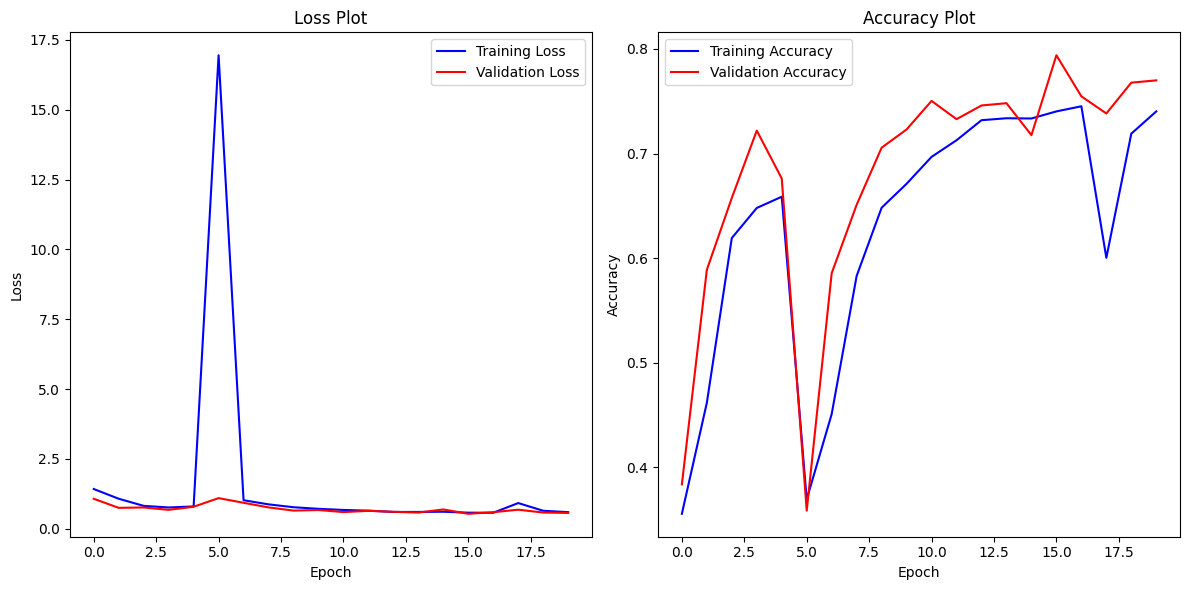

In [64]:
# Mengambil nilai loss dan akurasi dari history
loss = histo.history['loss']
val_loss = histo.history['val_loss']
acc = histo.history['accuracy']
val_acc = histo.history['val_accuracy']

# Mengatur ukuran plot
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

In [65]:
test_loss, test_score = new_vgg16.evaluate(image_test, label_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

58/58 [==============================] - 96s 2s/step - loss: 0.6062 - accuracy: 0.7462
Loss on test set:  0.6062408089637756
Accuracy on test set:  0.7461873888969421


In [66]:
# Get predictions
preds = new_vgg16.predict(image_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(label_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

58/58 [==============================] - 87s 1s/step
(918,)
(918,)


<Figure size 640x480 with 0 Axes>

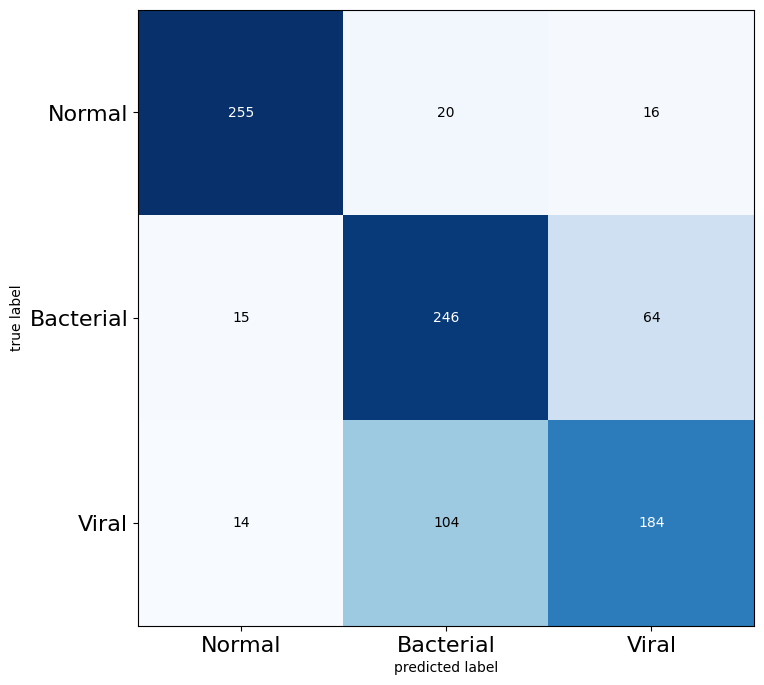

In [67]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.show()

In [68]:
nn, nb, nv, bn, bb, bv, vn, vb, vv = cm.ravel()
normal_precision = nn/(nn+bn+vn)
normal_recall = nn/(nn+nb+nv)
bacterial_precision = bb/(nb+bb+vb)
bacterial_recall = nn/(bn+bb+bv)
viral_precision = nn/(nv+bv+vv)
viral_recall = nn/(vn+vb+vv)
print("Recall of the model when dealing with heathly lungs is {:.2f}".format(normal_recall))
print("Precision of the model when dealing with heathly lungs is {:.2f}".format(normal_precision))
print("Recall of the model when dealing with bacterial pneumonia is {:.2f}".format(bacterial_recall))
print("Precision of the model when dealing with bacterial pneumonia is {:.2f}".format(bacterial_precision))
print("Recall of the model when dealing with viral pneumonia is {:.2f}".format(viral_recall))
print("Precision of the model when dealing with viral pneumonia is {:.2f}".format(viral_precision))

Recall of the model when dealing with heathly lungs is 0.88
Precision of the model when dealing with heathly lungs is 0.90
Recall of the model when dealing with bacterial pneumonia is 0.78
Precision of the model when dealing with bacterial pneumonia is 0.66
Recall of the model when dealing with viral pneumonia is 0.84
Precision of the model when dealing with viral pneumonia is 0.97


## Retrain Model

In [70]:
from tensorflow.keras.models import load_model

model = load_model('80_79.h5')

In [71]:
batch_size = 16

histo = model.fit(image_train, label_train, \
                    validation_data=(image_validate, label_validate), \
                    epochs=2, callbacks=[early_stopping_monitor], batch_size=batch_size)

Epoch 1/2
268/268 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.8068WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1612s 6s/step - loss: 0.5120 - accuracy: 0.8068 - val_loss: 0.3788 - val_accuracy: 0.8462
Epoch 2/2
268/268 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8795WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1505s 6s/step - loss: 0.3217 - accuracy: 0.8795 - val_loss: 0.3208 - val_accuracy: 0.8724


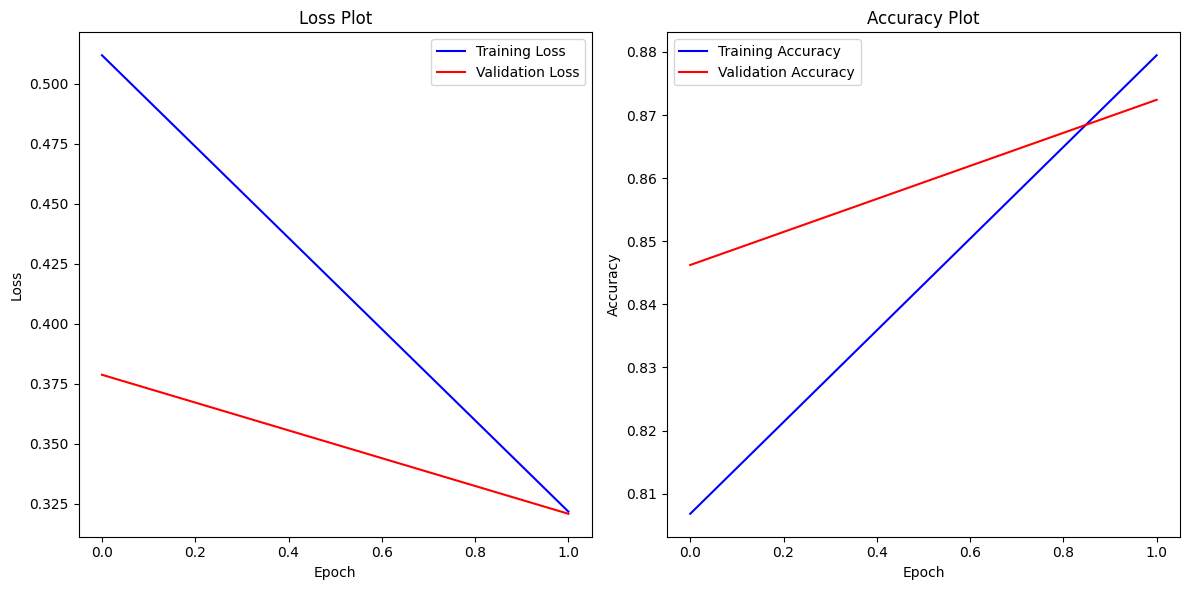

In [72]:
# Mengambil nilai loss dan akurasi dari history
loss = histo.history['loss']
val_loss = histo.history['val_loss']
acc = histo.history['accuracy']
val_acc = histo.history['val_accuracy']

# Mengatur ukuran plot
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

In [74]:
test_loss, test_score = model.evaluate(image_test, label_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

58/58 [==============================] - 72s 1s/step - loss: 0.3394 - accuracy: 0.8791
Loss on test set:  0.33941414952278137
Accuracy on test set:  0.8790849447250366


In [75]:
# Get predictions
preds = model.predict(image_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(label_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

58/58 [==============================] - 73s 1s/step
(918,)
(918,)


<Figure size 640x480 with 0 Axes>

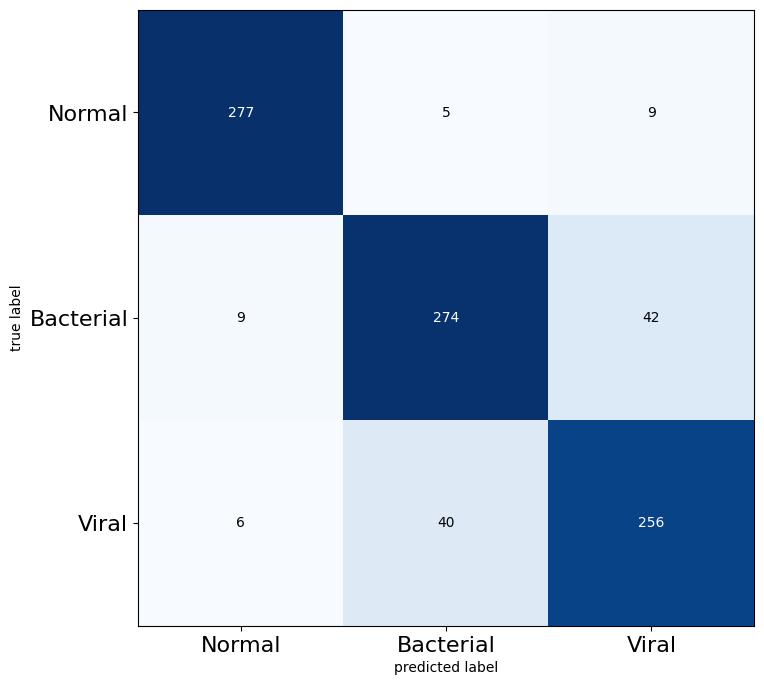

In [76]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.show()

In [77]:
model.save('87_87.h5')

c:\Users\AJEM\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 2nd Retrain Model

In [78]:
from tensorflow.keras.models import load_model

model = load_model('87_87.h5')

In [79]:
batch_size = 16

histo = model.fit(image_train, label_train, \
                    validation_data=(image_validate, label_validate), \
                    epochs=4, callbacks=[early_stopping_monitor], batch_size=batch_size)

Epoch 1/4
268/268 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9154WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1586s 6s/step - loss: 0.2238 - accuracy: 0.9154 - val_loss: 0.4017 - val_accuracy: 0.8441
Epoch 2/4
268/268 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9444WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1462s 5s/step - loss: 0.1549 - accuracy: 0.9444 - val_loss: 0.3911 - val_accuracy: 0.8604
Epoch 3/4
268/268 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9603WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1429s 5s/step - loss: 0.1103 - accuracy: 0.9603 - val_loss: 0.3991 - val_accuracy: 0.8582
Epoch 4/4
268/268 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9666WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy


268/268 [==============================] - 1435s 5s/step - loss: 0.0907 - accuracy: 0.9666 - val_loss: 0.4897 - val_accuracy: 0.8735


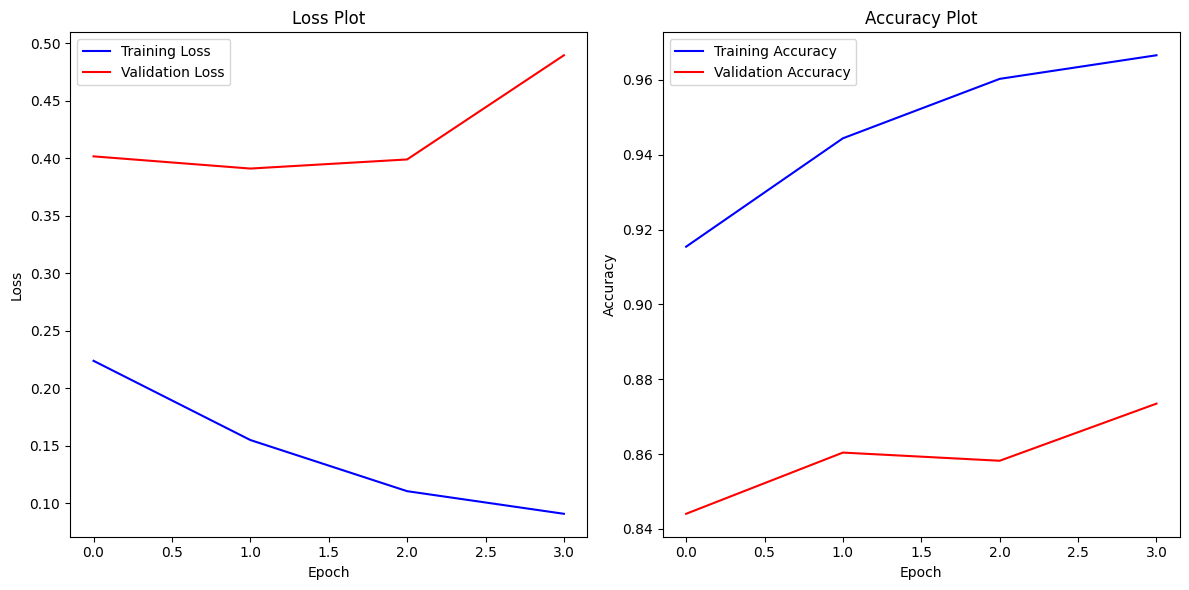

In [80]:
# Mengambil nilai loss dan akurasi dari history
loss = histo.history['loss']
val_loss = histo.history['val_loss']
acc = histo.history['accuracy']
val_acc = histo.history['val_accuracy']

# Mengatur ukuran plot
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot akurasi
plt.subplot(1, 2, 2)
plt.plot(acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

In [81]:
test_loss, test_score = model.evaluate(image_test, label_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

58/58 [==============================] - 71s 1s/step - loss: 0.5399 - accuracy: 0.8747
Loss on test set:  0.5398501753807068
Accuracy on test set:  0.8747276663780212


In [82]:
# Get predictions
preds = model.predict(image_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(label_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

58/58 [==============================] - 75s 1s/step
(918,)
(918,)


<Figure size 640x480 with 0 Axes>

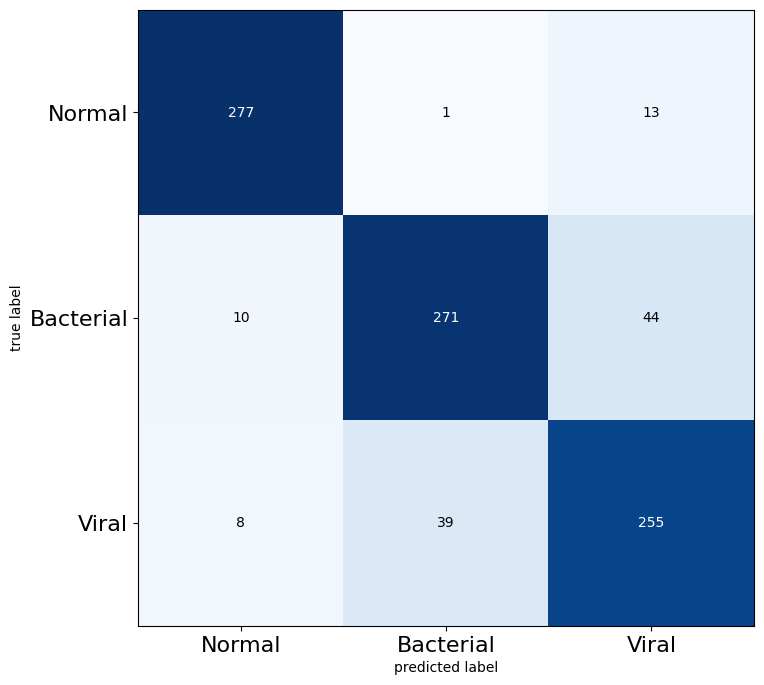

In [83]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.yticks(range(3), ['Normal', 'Bacterial', 'Viral'], fontsize=16)
plt.show()

In [84]:
model.save('90_87.h5')

c:\Users\AJEM\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
